## 환경설정

1. http://braincrew2.iptime.org:8001 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 기입하시는 것을 권장 드려요. 예. 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.


In [ ]:
project = "SIMPSON"  # 수정하지 마세요
username = "g4312@naver.com"  # 이메일아이디 (예시. abc@hello.com)
password = "1234"  # 비밀번호

아래의 코드를 순서대로 실행해 주세요.


In [ ]:
import os
import requests

if not os.path.exists("competition.py"):
    url = "https://link.teddynote.com/COMPT"
    file_name = "competition.py"
    response = requests.get(url)
    with open(file_name, "wb") as file:
        file.write(response.content)

아래 코드를 실행하여 데이터를 다운로드 받습니다.


In [ ]:
import competition

# 파일 다운로드
# competition.download_competition_files("MNIST")
competition.download_competition_files(
    "https://link.teddynote.com/SIMPSON", use_competition_url=False
)

100%|██████████| 11.4M/11.4M [00:00<00:00, 54.8MiB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Data 경로 설정
DATA_DIR = "data"

# 경고 무시
warnings.filterwarnings("ignore")

SEED = 123

## 데이터 로드


In [ ]:
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test["FilePath"] = test["FilePath"].str.replace("./test_data/", "./data/test/")
test.head()

,FilePath
0,./data/test/0027b80dd098.jpg
1,./data/test/005b15b22e3c.jpg
2,./data/test/0095881c3257.jpg
3,./data/test/00cea80c4825.jpg
4,./data/test/00d8f6050dcf.jpg


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 이미지 전처리 정의
train_transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),  # 이미지 크기를 (28, 28)로 조정, 딥러닝을 일정크기의 사진으로 들어가야 한다
        transforms.Grayscale(num_output_channels=1),  # 흑백 이미지로 변환
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    ]
)

# ImageFolder를 사용하여 데이터셋 생성
train_dataset = datasets.ImageFolder(root="./data/train", transform=train_transform)

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

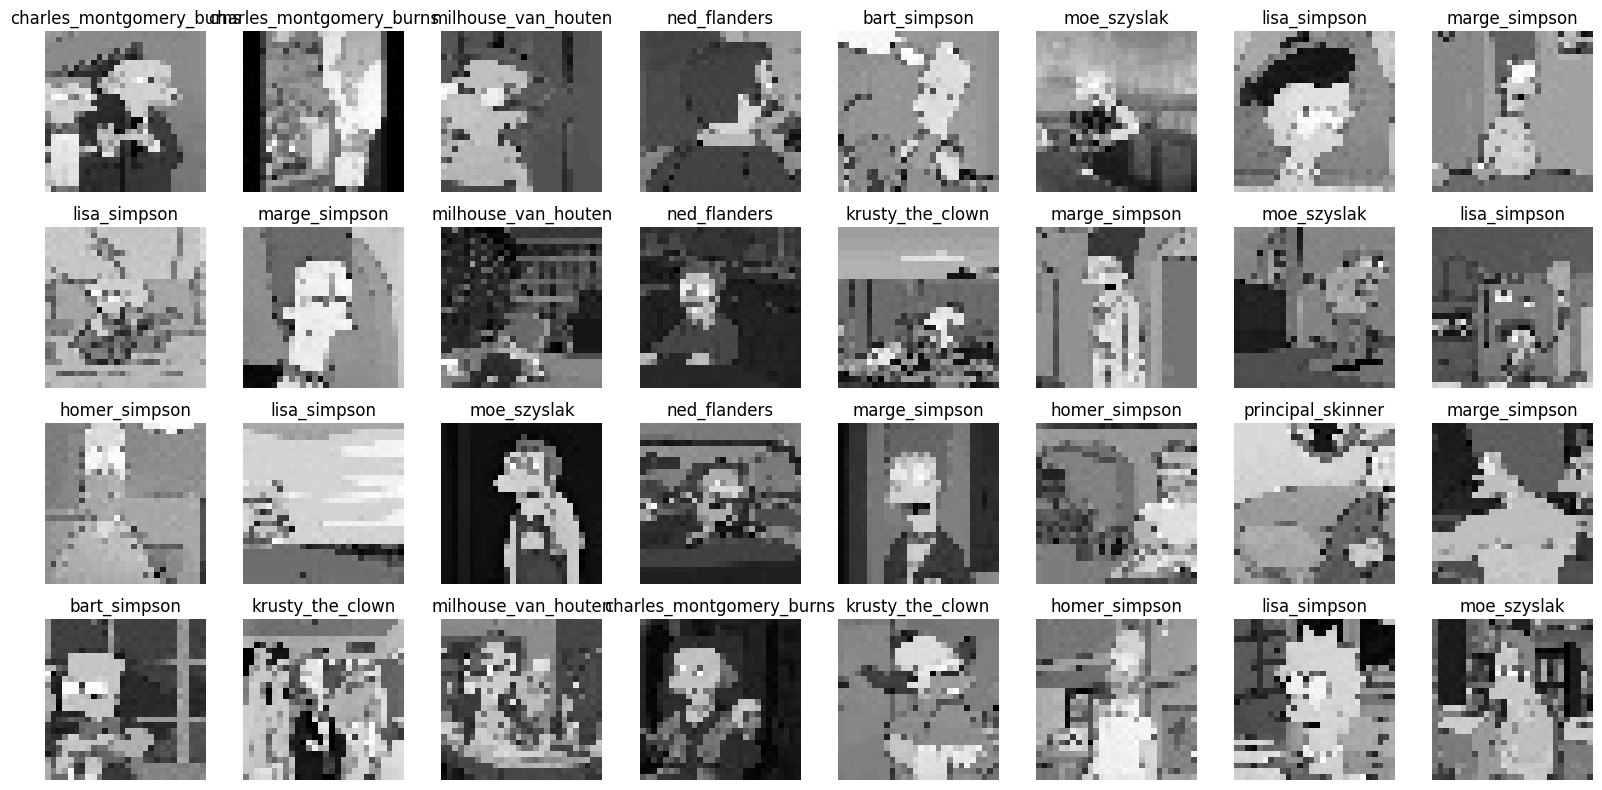

In [ ]:
# 숫자 라벨을 클래스 이름으로 매핑하는 딕셔너리 생성
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# train_loader에서 첫 번째 배치 가져오기
images, labels = next(iter(train_loader))

# 4x8 그리드로 이미지와 라벨 시각화
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# 각 subplot에 이미지와 라벨을 그리기
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img.numpy().squeeze(), cmap="gray")  # 이미지를 그레이스케일로 표시
    ax.set_title(
        idx_to_class[label.item()], fontsize=12
    )  # 각 이미지 위에 라벨(클래스 이름)을 타이틀로 추가
    ax.axis("off")  # 축 제거

plt.tight_layout()  # subplot 간격 조정
plt.show()

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # 'FilePath' 열에서 이미지 경로 가져오기
        image = Image.open(img_path).convert("L")  # 이미지를 흑백으로 로드

        if self.transform:
            image = self.transform(image)

        return image


# 이미지를 불러올 때 적용할 전처리 정의
test_transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),  # 이미지 크기를 (28, 28)로 조정
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    ]
)

# 커스텀 데이터셋 인스턴스 생성
custom_dataset = CustomImageDataset(dataframe=test, transform=test_transform)

# DataLoader 인스턴스 생성
test_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

shape 를 확인합니다.


In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
x = next(iter(test_loader))
x.shape

torch.Size([1, 1, 28, 28])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
        nn.Linear(28*28,256),
        nn.LeakyReLU(),
        nn.Linear(256,128),
        nn.LeakyReLU(),

        nn.Linear(128,32),
        nn.LeakyReLU(),
        nn.Linear(32,10)
        )
        # 코드입력

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 28*28)
        x = x.view(-1, 28 * 28)
        # 코드입력
        x = self.fc(x)

        return x

cuda:0


In [ ]:
# 모델 생성
model = Net(num_classes=10)

# 모델을 device 에 올립니다. (cuda:0 혹은 cpu)
model.to(device)
model

Net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

### Loss Function & Optimizer


In [ ]:
# Loss function 정의
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 설정: model.paramters()와 learning_rate 설정
optimizer = optim.Adam(model.parameters(), lr=0.003)

### 모델 학습(Training)


In [ ]:
# 최대 반복 횟수 정의
num_epoch = 20

# loss 기록하기 위한 list 정의
losses = []
accs = []

# 훈련 모드 활성화
model.train()

for epoch in range(num_epoch):
    # loss 초기화
    running_loss = 0
    # 정확도 계산
    running_acc = 0

    for x, y in train_loader:
        # x, y 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        x = x.to(device)
        y = y.to(device)

        # 그라디언트 초기화 (초기화를 수행하지 않으면 계산된 그라디언트는 누적됩니다.)
        optimizer.zero_grad()


        # output 계산
        output = model(x)

        # 손실(loss) 계산 (예측 Prediction, 실제 Ground Truth)
        loss = loss_fn(output, y)

        # 미분 계산
        loss.backward()


        # 경사하강법 계산 및 적용
        optimizer.step()


        # 배치별 loss 를 누적합산 합니다.
        running_loss += loss.item()
        running_acc += output.argmax(dim=1).eq(y).sum().item() / len(y)

    # 누적합산된 배치별 loss값을 배치의 개수로 나누어 Epoch당 loss를 산출합니다.
    loss = running_loss / len(train_loader)
    losses.append(loss)
    acc = running_acc / len(train_loader)
    accs.append(acc)

    # 매 Epoch의 학습이 끝날때 훈련 결과를 출력합니다.
    print(f"{epoch:03d} loss = {loss:.5f}, accuracy = {acc:.5f}")

000 loss = 2.43514, accuracy = 0.14613
001 loss = 2.36378, accuracy = 0.16925
002 loss = 2.37755, accuracy = 0.17775
003 loss = 2.30607, accuracy = 0.17950
004 loss = 2.30071, accuracy = 0.17988
005 loss = 2.28388, accuracy = 0.18475
006 loss = 2.27439, accuracy = 0.18588
007 loss = 2.67302, accuracy = 0.18987
008 loss = 2.47631, accuracy = 0.14675
009 loss = 2.37570, accuracy = 0.15925
010 loss = 2.38194, accuracy = 0.16550
011 loss = 2.31922, accuracy = 0.16387
012 loss = 2.30986, accuracy = 0.18050
013 loss = 2.27518, accuracy = 0.18338
014 loss = 2.29787, accuracy = 0.18550
015 loss = 2.26048, accuracy = 0.18887
016 loss = 2.26078, accuracy = 0.19987
017 loss = 2.27169, accuracy = 0.20375
018 loss = 2.24931, accuracy = 0.20375
019 loss = 2.19105, accuracy = 0.21600


### 예측


In [ ]:
predictions = []

# 검증모드 진입
model.eval()

with torch.no_grad():
    # loss 초기화
    running_loss = 0
    # 정확도 계산
    running_acc = 0
    for x in test_loader:
        x = x.to(device)

        y_hat = model(x)
        label = y_hat.argmax(dim=1).detach().item()
        predictions.append(label)

In [ ]:
# 정답
your_answer = [idx_to_class[l] for l in predictions]

## 결과 제출

- 느리다고 중지 후 다시 평가 코드를 실행하는 경우 제출 과정에서 패널티가 발생할 수 있습니다. (제출 횟수 이슈 발생 가능)
- 제출결과는 [대회페이지](http://braincrew2.iptime.org:8001/competitions/ADVHOUSE/)의 `리더보드` 와 `제출` 탭에서 확인할 수 있습니다.


아래 Cell을 실행하여 예측 결과 업데이트


In [ ]:
import competition

# 예측 결과 업데이트
submission = pd.read_csv(os.path.join(DATA_DIR, "submission.csv"))
submission["Label"] = your_answer

display(submission)
competition.submit(project, username, password, submission)

,FilePath,Label
0,./test_data/0027b80dd098.jpg,bart_simpson
1,./test_data/005b15b22e3c.jpg,bart_simpson
2,./test_data/0095881c3257.jpg,milhouse_van_houten
3,./test_data/00cea80c4825.jpg,bart_simpson
4,./test_data/00d8f6050dcf.jpg,bart_simpson
...,...,...
1995,./test_data/ff4b83998ab2.jpg,ned_flanders
1996,./test_data/ff71e9a150ae.jpg,bart_simpson
1997,./test_data/ff80ecf57714.jpg,bart_simpson
1998,./test_data/ff82162d181e.jpg,charles_montgomery_burns


ConnectionError: HTTPConnectionPool(host='braincrew2.iptime.org', port=8001): Max retries exceeded with url: /api/token-auth/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb5612cb730>: Failed to establish a new connection: [Errno 111] Connection refused'))